# Localise sources in counts map

This notebook uses deep learning to explore source localisation with CTA.

## Gather data and label info

First we gather all info of simulations and relative counts maps.

In [16]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import join, isfile

source = 'crab'
simdata = f'/data01/homes/dipiano/E4/irf_random/{source}/sim/merged_simulator_data.dat'
mapdata = f'/data01/homes/dipiano/E4/irf_random/{source}/map/merged_mapper_data.dat'
fitspath = f'/data01/homes/dipiano/E4/irf_random/{source}/sim'

fitsfiles = [join(fitspath, f) for f in listdir(fitspath) if '.fits' in f and isfile(join(fitspath, f))]
fitsfiles = sorted(fitsfiles)
f"Dataset size: {len(fitsfiles)}"

'Dataset size: 50000'

### Simulations info

In [17]:
siminfo = pd.read_csv(simdata, sep=' ', header=0).sort_values('seed')
siminfo.rename(columns={'computation_time': 'sim_time'}, inplace=True)
siminfo.reset_index(inplace=True, drop=True)
siminfo.head()

,name,seed,start,stop,duration,source_ra,source_dec,point_ra,point_dec,offset,irf,fov,sim_time
0,crab_00001,1,0,600,600,83.6331,22.0145,84.483058,22.795885,1.108162,random,2.5,7.936944
1,crab_00002,2,0,600,600,83.6331,22.0145,85.267299,23.505055,2.119538,random,2.5,8.025033
2,crab_00003,3,0,600,600,83.6331,22.0145,85.517764,23.729140,2.440284,random,2.5,9.573038
3,crab_00004,4,0,600,600,83.6331,22.0145,84.535205,22.843393,1.175743,random,2.5,7.915744
4,crab_00005,5,0,600,600,83.6331,22.0145,84.566758,22.872115,1.216613,random,2.5,7.643670


### Maps info

In [18]:
#mapinfo = pd.read_csv(mapdata, sep=' ', header=0).sort_values('seed')
#mapinfo.rename(columns={'computation_time': 'map_time'}, inplace=True)
#mapinfo.reset_index(inplace=True, drop=True)
#mapinfo.head()

### Merge info tables

In [19]:
#datainfo = pd.merge(siminfo, mapinfo, on=["name", "seed"])
#datainfo.head()

In [20]:
#datainfo.to_csv(simdata.replace(f'_simulator_', '_'))
datainfo = siminfo

## Gather dataset

Now we gather all data from the fits files and convert to numpy arrays. Here we need to set some parameters such as the exposure time we want to use (for now it will be fixed exposure time).

In [39]:
def extract_heatmap(data, trange, smoothing, nbins):
    data = data[(data['TIME'] >= trange[0]) & (data['TIME'] <= trange[1])] 
    
    ra = data['RA'].to_numpy()
    dec = data['DEC'].to_numpy()
    
    heatmap, xe, ye = np.histogram2d(ra, dec, bins=nbins)
    heatmap = gaussian_filter(heatmap, sigma=smoothing)
    return heatmap.T

def set_wcs(point_ra, point_dec, point_ref, pixelsize):
    w = WCS(naxis=2)
    w.wcs.ctype = ['RA---CAR', 'DEC--CAR']
    w.wcs.cunit = ['deg', 'deg']
    w.wcs.crpix = [point_ref, point_ref]
    w.wcs.crval = [point_ra, point_dec]
    w.wcs.cdelt = [pixelsize, pixelsize]
    #w.wcs.lonpole = 0.0
    #w.wcs.latpole = 67.49
    return w

Simulation: crab_00001
Point: [84.48305784361412, 22.79588543207404]
Source: [83.6331, 22.0145]
Simulation: crab_00002
Point: [85.26729867168108, 23.50505536393284]
Source: [83.6331, 22.0145]
Simulation: crab_00003
Point: [85.51776427361322, 23.72914027919522]
Source: [83.6331, 22.0145]
Simulation: crab_00004
Point: [84.53520456097816, 22.8433933546625]
Source: [83.6331, 22.0145]
Simulation: crab_00005
Point: [84.56675774348273, 22.87211533068694]
Source: [83.6331, 22.0145]
Simulation: crab_00006
Point: [83.79064547442871, 22.160332677998262]
Source: [83.6331, 22.0145]
Simulation: crab_00007
Point: [84.74905349571567, 23.037694301285647]
Source: [83.6331, 22.0145]
Simulation: crab_00008
Point: [84.8472330825339, 23.1266162389037]
Source: [83.6331, 22.0145]
Simulation: crab_00009
Point: [84.09127916878873, 22.43735841608872]
Source: [83.6331, 22.0145]
Simulation: crab_00010
Point: [85.15882789840668, 23.407647204277207]
Source: [83.6331, 22.0145]


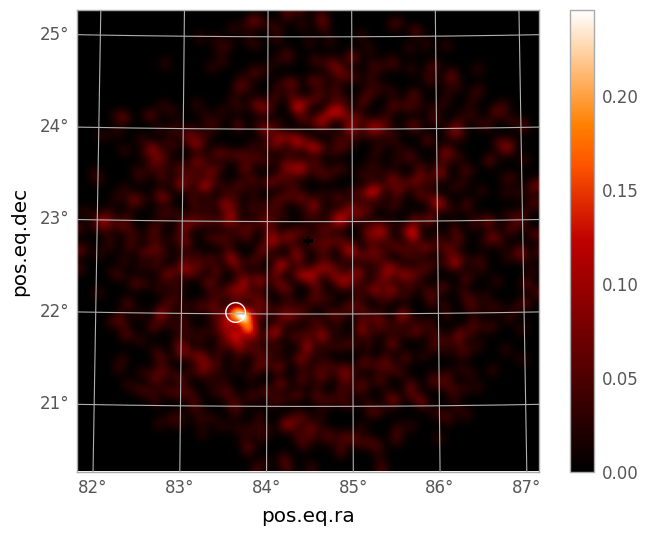

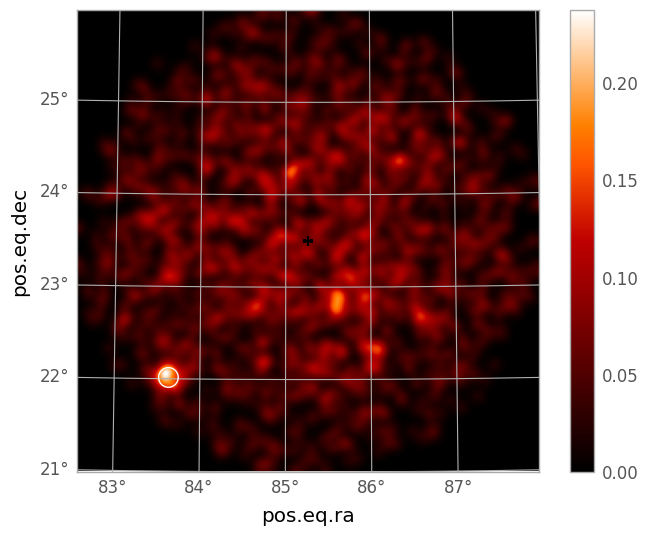

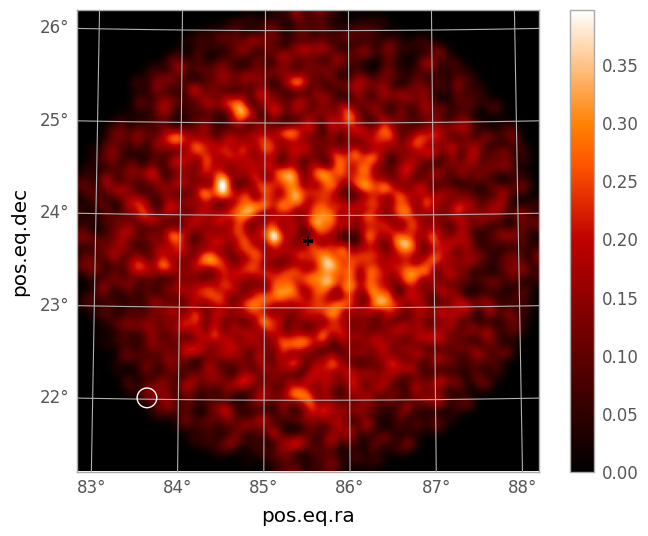

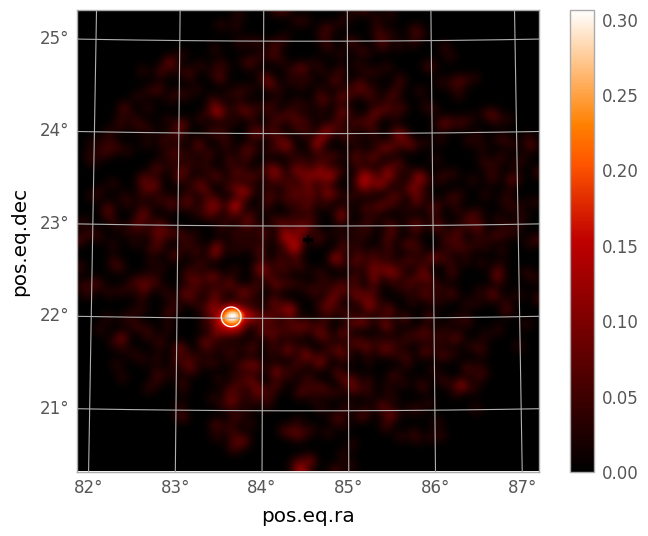

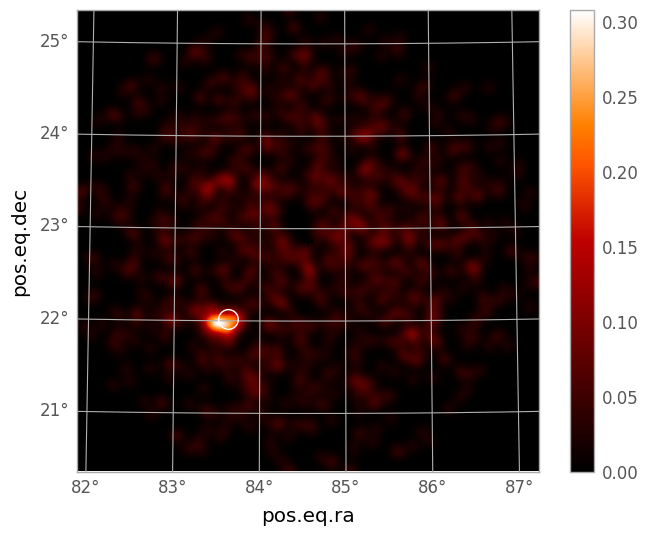

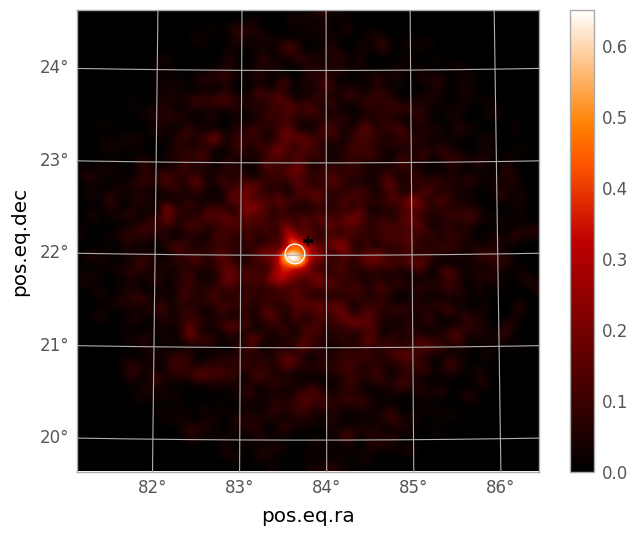

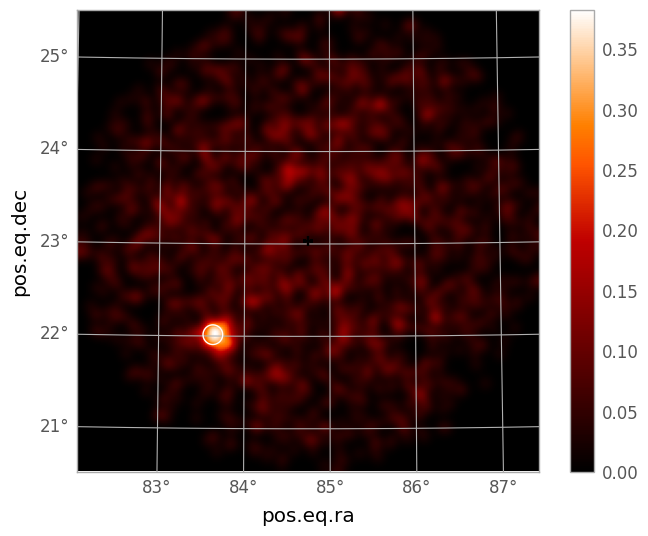

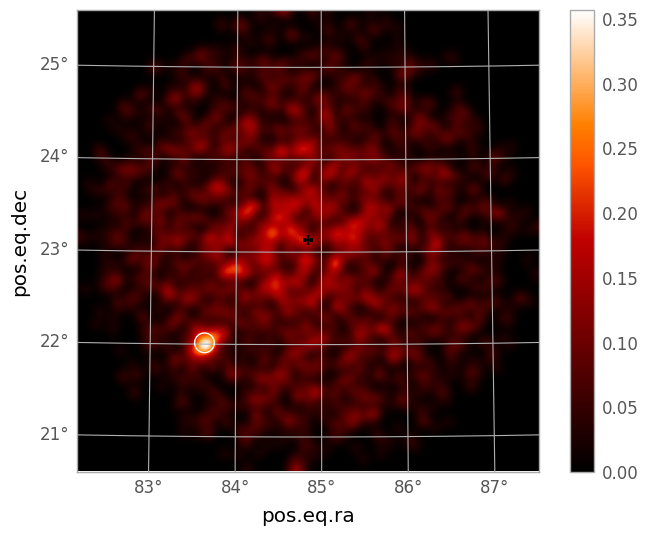

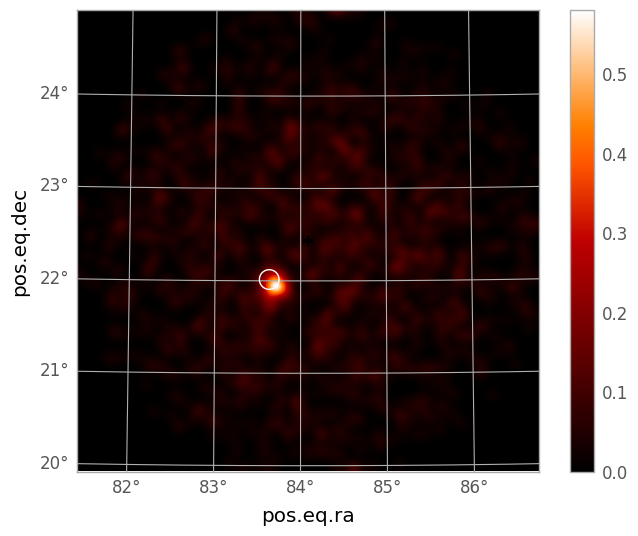

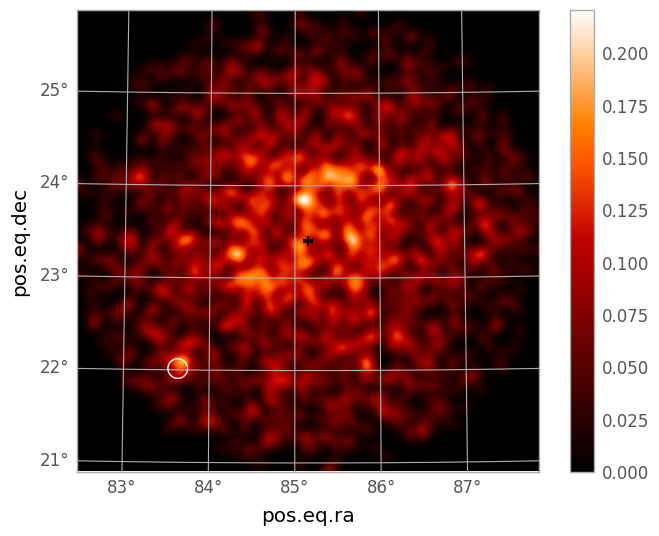

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
from os.path import basename
from astropy.io import fits
from scipy.ndimage import gaussian_filter
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization import astropy_mpl_style
from astropy import units as u
from astropy.wcs import WCS
from matplotlib.colors import SymLogNorm
from astropy.table import Table, vstack
plt.style.use(astropy_mpl_style)

trange = [0, 50]
smoothing = 3
pixelsize = 0.02
nbins = int(5/pixelsize)
sample = 10

for f in fitsfiles[:sample]:
    name = basename(f).replace('.fits','')
    print(f"Simulation: {name}")

    point_ra = datainfo[datainfo['name'] == name]['point_ra'].to_numpy()[0]
    point_dec = datainfo[datainfo['name'] == name]['point_dec'].to_numpy()[0]
    print(f"Point: [{point_ra}, {point_dec}]")
    
    heatmap = Table.read(f, hdu=1).to_pandas()
    heatmap = extract_heatmap(heatmap, trange, smoothing, nbins)
    wcs = set_wcs(point_ra=point_ra, point_dec=point_dec, point_ref=nbins/2+0.5, pixelsize=pixelsize)

    plt.figure()
    ax = plt.subplot(projection=wcs)
    ax.coords[0].set_format_unit(u.deg)
    ax.coords[1].set_format_unit(u.deg)
    ax.invert_yaxis()
    ax.invert_xaxis()

    plt.imshow(heatmap)
    #plt.imshow(heatmap, norm=SymLogNorm(1, base=10))
    plt.colorbar()
    
    plt.scatter(point_ra, point_dec, c='k', marker='+', s=50, transform=ax.get_transform('world')) 
    if 'background' not in name:
        source_ra = datainfo[datainfo['name'] == name]['source_ra'].to_numpy()[0]
        source_dec = datainfo[datainfo['name'] == name]['source_dec'].to_numpy()[0]
        print(f"Source: [{source_ra}, {source_dec}]")
        plt.scatter(source_ra * u.deg, source_dec * u.deg, c='none', marker='o', s=200, transform=ax.get_transform('world'), edgecolor='w', facecolor='none')
    
